In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir kaggle

In [ ]:
import os
import json 
# kaggleAPIToken = {"username":"phamnguyenduytien","key":"1e4b0f7feacd5a7ffc437586095ab21c"}
kaggleAPIToken = {"username":"phamnguyenduytien","key":"77412902a4e3a9fd98cb092119fea134"}
with open('/content/kaggle/kaggle.json', 'w') as file:
    json.dump(kaggleAPIToken, file)

In [ ]:
!chmod 600 /content/kaggle/kaggle.json
!sudo mkdir ~/.kaggle
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json
!mkdir dataset
# !kaggle datasets download -d phamnguyenduytien/alzheimer-datasets-5-classes
!kaggle datasets download -d phamnguyenduytien/alzheimers-disease-5-classes

 33% 5.00M/14.9M [00:00<00:00, 43.3MB/s]
100% 14.9M/14.9M [00:00<00:00, 99.2MB/s]


In [ ]:
!unzip /content/alzheimers-disease-5-classes.zip

Archive:  /content/alzheimers-disease-5-classes.zip
  inflating: Alzheimer 5 classes/test/Mild/mildDem (1).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (10).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (11).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (12).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (13).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (14).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (15).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (16).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (17).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (18).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (19).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (2).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (20).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (21).jpg  
  inflating: Alzheimer 5 classes/test/Mild/mildDem (22).jpg  
  inflating: Alzheim

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
base_path = "/content/Alzheimer 5 classes/train/"

In [ ]:
categories = ['MildDemented','ModerateDemented','NonDemented','SevereDemented','VeryMildDemented']

In [ ]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [ ]:
filenames_list = []
categories_list = []

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = pd.DataFrame(columns= ['image_path','category'])

for category in categories:
    filenames = os.listdir(base_path + category + "/")
    for filename in filenames:
        file_path = base_path + category+"/"+filename
        df2 = {'image_path': file_path, 'category': category}
        df = df.append(df2, ignore_index = True)

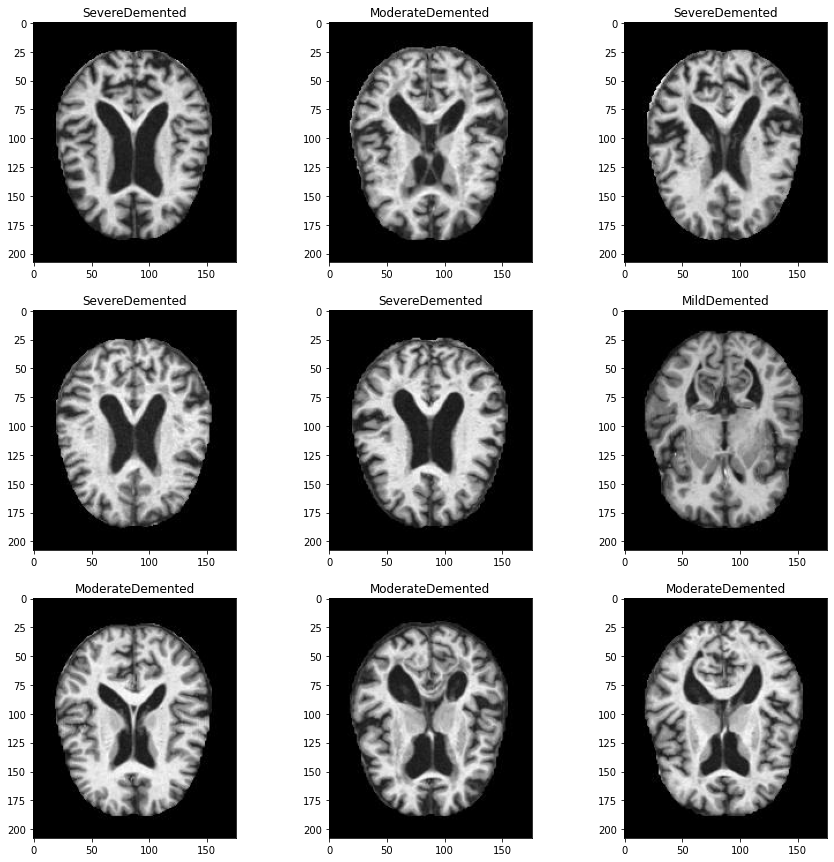

In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = image.load_img(sample['image_path'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

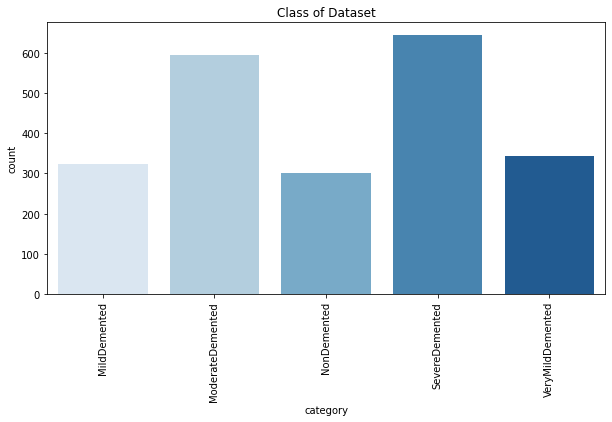

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('Class of Dataset')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(1766, 221, 221)

**CNN**

In [ ]:
im_shape = (256,256)
batch_size = 64
seed = 42

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_path,
    x_col='image_path',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 1766 validated image filenames belonging to 5 classes.


In [ ]:
val_generator = val_data_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_path,
    x_col='image_path',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 221 validated image filenames belonging to 5 classes.


In [ ]:
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='image_path',
    y_col='category',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 221 validated image filenames belonging to 5 classes.


In [ ]:
nb_train_samples = train_generator.samples
nb_validation_samples = val_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'SevereDemented', 'VeryMildDemented']


**MODEL**

In [ ]:
from tensorflow.keras.optimizers import SGD

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

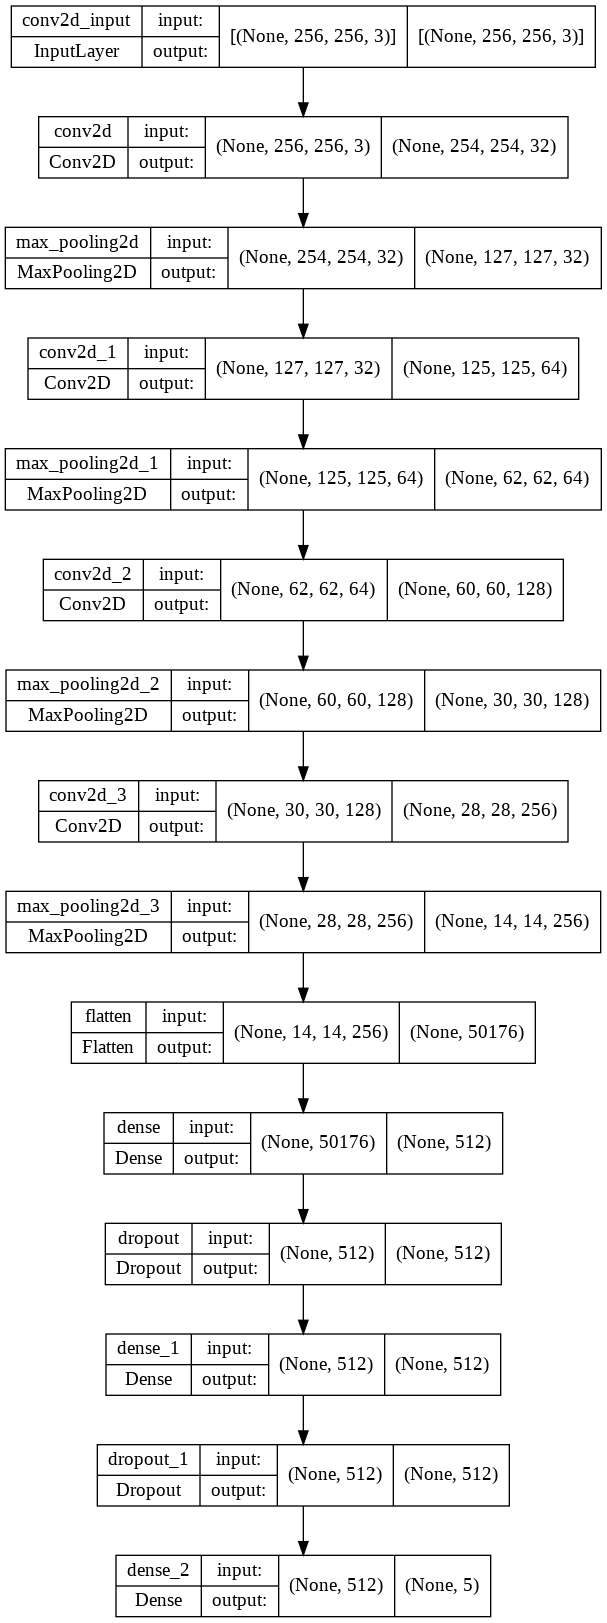

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(im_shape[0], im_shape[1], 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
file_save = '/content/drive/MyDrive/Colab Notebooks/best.hdf5'
checkPoint = ModelCheckpoint(file_save,monitor='val_loss', save_best_only=True, mode='auto')

#  Hiển thị hàm model.summary() dưới dạng biểu đồ 
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes = True)


In [ ]:
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.1,
    rescale=1./255,
	width_shift_range=0.1,
    height_shift_range=0.1,
	horizontal_flip=True,
    brightness_range=[0.2,1.5], fill_mode="nearest")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch=8,
        epochs=40,
        validation_data=val_generator,
        validation_steps=2)

Epoch 1/40
8/8 [==============================] - 17s 376ms/step - loss: 1.6300 - accuracy: 0.2675 - val_loss: 1.6523 - val_accuracy: 0.2422
Epoch 2/40
8/8 [==============================] - 2s 200ms/step - loss: 1.5226 - accuracy: 0.3292 - val_loss: 1.4392 - val_accuracy: 0.3359
Epoch 3/40
8/8 [==============================] - 2s 194ms/step - loss: 1.4521 - accuracy: 0.3281 - val_loss: 1.2444 - val_accuracy: 0.4844
Epoch 4/40
8/8 [==============================] - 2s 194ms/step - loss: 1.0839 - accuracy: 0.5352 - val_loss: 0.4760 - val_accuracy: 0.8594
Epoch 5/40
8/8 [==============================] - 2s 194ms/step - loss: 0.6232 - accuracy: 0.7305 - val_loss: 0.2555 - val_accuracy: 0.8672
Epoch 6/40
8/8 [==============================] - 2s 197ms/step - loss: 0.4207 - accuracy: 0.8281 - val_loss: 0.2936 - val_accuracy: 0.8594
Epoch 7/40
8/8 [==============================] - 2s 192ms/step - loss: 0.3713 - accuracy: 0.8498 - val_loss: 0.1950 - val_accuracy: 0.9375
Epoch 8/40
8/8 [===

### Đánh giá mô hình

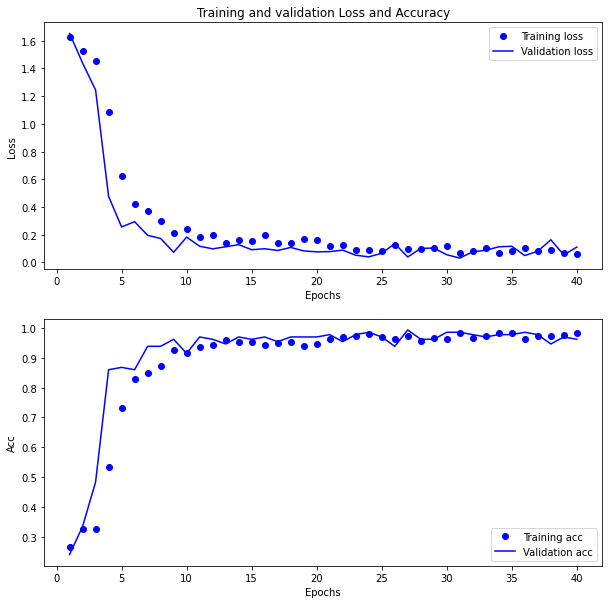

In [ ]:
# Training curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
# Using the validation dataset
score = model.evaluate(val_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

4/4 [==============================] - 1s 184ms/step - loss: 0.1087 - accuracy: 0.9548
Val loss: 0.10870789736509323
Val accuracy: 0.9547511339187622


In [ ]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

221/221 [==============================] - 1s 5ms/step - loss: 0.2308 - accuracy: 0.9231
Test loss: 0.23079049587249756
Test accuracy: 0.9230769276618958


Classification Report
                  precision    recall  f1-score   support

    MildDemented       0.94      0.76      0.84        38
ModerateDemented       0.92      0.95      0.93        60
     NonDemented       0.76      1.00      0.87        26
  SevereDemented       1.00      0.92      0.96        60
VeryMildDemented       0.95      1.00      0.97        37

        accuracy                           0.92       221
       macro avg       0.91      0.93      0.91       221
    weighted avg       0.93      0.92      0.92       221



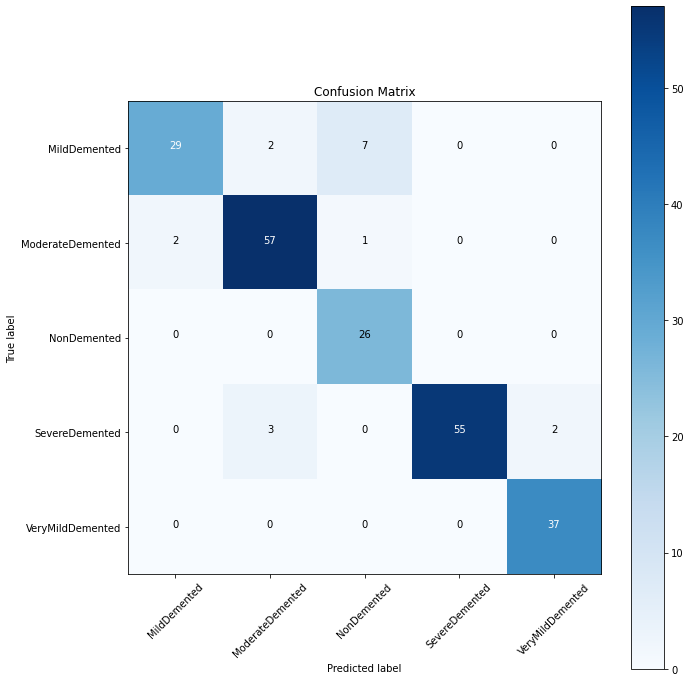

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

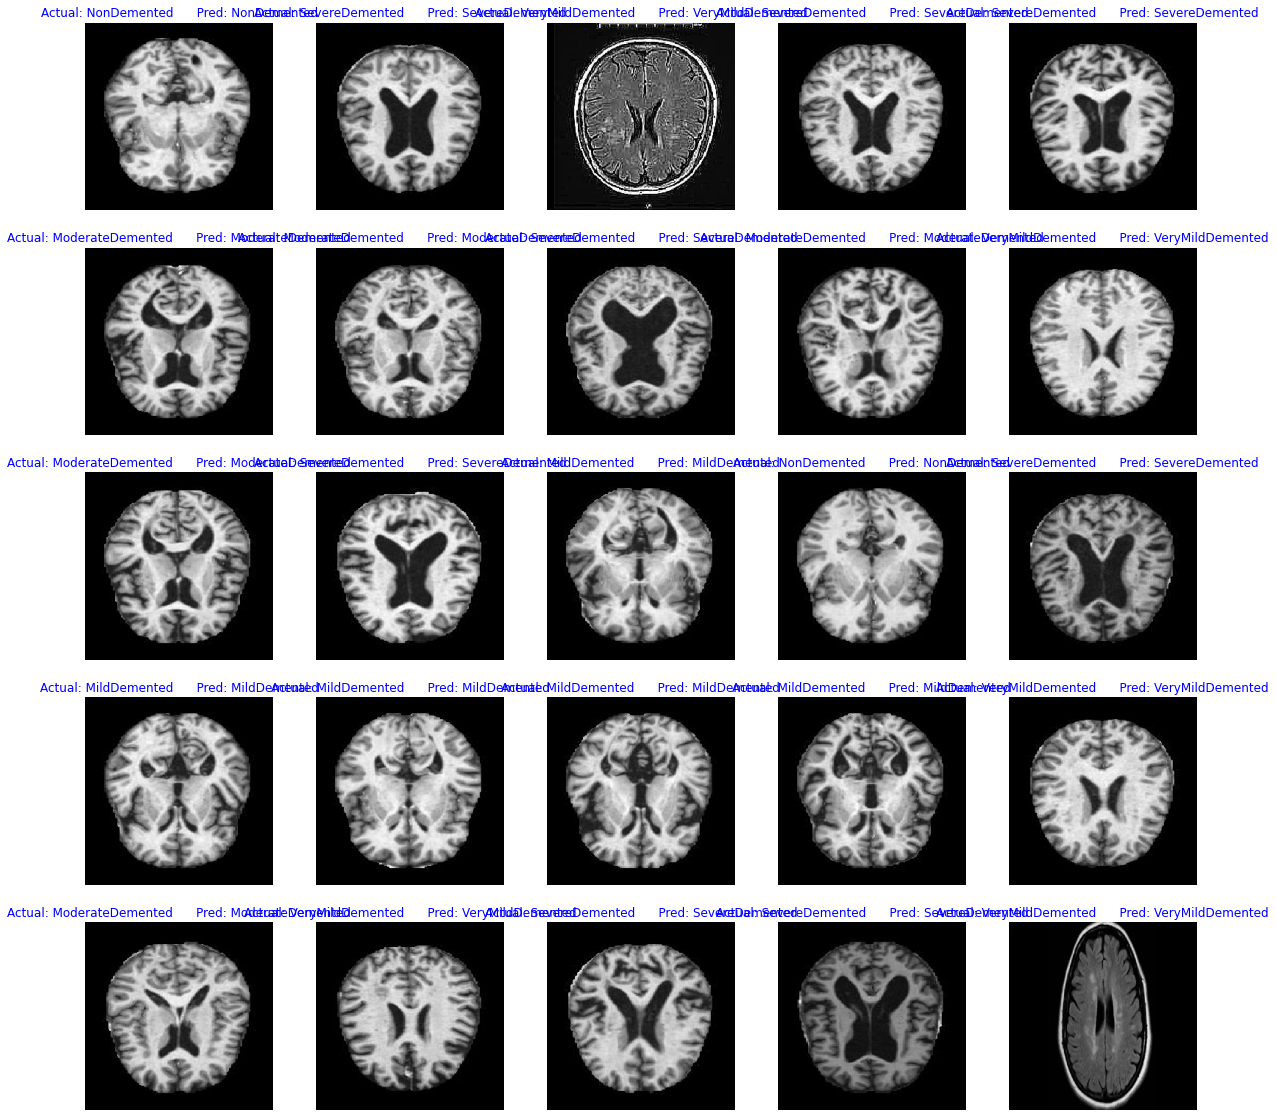

In [ ]:
def test_image_samples(gen ):
    
        t_dict=gen.class_indices
        classes=list(t_dict.keys())    
        images,labels=next(gen) # get a sample batch from the generator 
        preds = model.predict(images)
        preds = preds.argmax(1)
        plt.figure(figsize=(20, 20))
        length=len(labels)
        if length<25:   #show maximum of 25 images
            r=length
        else:
            r=25
        for i in range(r):
            plt.subplot(5, 5, i + 1)
            image=images[i]
            plt.imshow(image)
            index=np.argmax(labels[i])
            class_name=classes[index]
            class_name_pred=classes[preds[i]]
            plt.title('Actual: {}      Pred: {}'.format(class_name,class_name_pred),  color='blue', fontsize=12)
            plt.axis('off')
        plt.show()

test_image_samples(val_generator)

In [ ]:
model.save('model.h5')

In [ ]:
model = load_model('model.h5')

In [ ]:
!ls

'Alzheimer 5 classes'		    drive      model.png
 alzheimers-disease-5-classes.zip   kaggle     sample_data
 dataset			    model.h5  'veryMild (29).jpg'


In [ ]:
import cv2 as cv
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

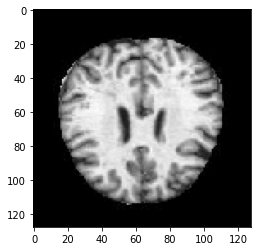

In [ ]:
img = load_img('/content/veryMild (29).jpg',target_size=(128,128))
plt.imshow(img)
img = img_to_array(img)

In [ ]:
img = cv.resize(img, dsize=(256, 256))
img = img.astype('float')*1./255
# Convert to tensor
img = np.expand_dims(img, axis=0)

In [ ]:
class_name = ['MildDemented','ModerateDemented','NonDemented','SevereDemented','VeryMildDemented']

In [ ]:
model_5 = load_model('model.h5')
predict = model_5.predict(img)
class_name[np.argmax(predict[0])], (predict[0])

('VeryMildDemented',
 array([7.7217572e-07, 2.5471611e-06, 3.9806586e-05, 3.0188849e-05,
        9.9992669e-01], dtype=float32))